# About
Here I want to explore different machine learning models for timeseries prediction. I use a real timeseries dataset that I found on from [Kaggle](www.kaggle.com).

I worked on this while taking the [DeepLearning.AI course "Sequences, Time Series and Prediction"](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction).

## Concepts covered
* Univariate timeseries
* Deep neural networks
* Recurrent neural networks (RNN)
* LSTM (Long short-term Memory) models
* Multilayer perceptron (MLP) model
* Convolutional layers

## Tools used
* Tensorfow: `tf.data.Dataset`, `tf.keras.Sequential`
* Kaggle API
* Pandas

# Imports, setup

In [329]:
import numpy as np
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from kaggle.api.kaggle_api_extended import KaggleApi

import tensorflow as tf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from scipy.signal import periodogram

## Download data from Kaggle
This step requires using the [Kaggle API](https://github.com/Kaggle/kaggle-api) and authenticating using the API credentials. In order to focus on model concepts rather than digging into the data, I pick a well-studied dataset: [monthly sunspot activity](https://www.kaggle.com/robervalt/sunspots/activity). This is the most popular sunspot dataset on Kaggle. As the data description states, sunspots are phenomena on the sun which vary with a approximately 11-year cycle. 

In [2]:
api = KaggleApi()
try:
    api.authenticate()
except Exception as e:
    print("Kaggle authentication failed!")
    raise e

sunspot_datasets = api.datasets_list(search='sunspots')
sunspot_datasets.sort(key=lambda d: (d['voteCount'], d['viewCount']), reverse=True)

for d in sunspot_datasets:
    # d is a dict
    print(f"\"{d['title']}\": \n\t votes: {d['voteCount']}; views: {d['viewCount']}; {d['url']}")

"Sunspots": 
	 votes: 84; views: 23743; https://www.kaggle.com/robervalt/sunspots
"Daily Sun Spot Data (1818 to 2019)": 
	 votes: 22; views: 4455; https://www.kaggle.com/abhinand05/daily-sun-spot-data-1818-to-2019
"climate change": 
	 votes: 15; views: 7542; https://www.kaggle.com/econdata/climate-change
"NASA and NOAA  Satellites Solar-Wind Dataset": 
	 votes: 8; views: 893; https://www.kaggle.com/arashnic/soalr-wind
"RiseInTemp_dataset": 
	 votes: 6; views: 2407; https://www.kaggle.com/vageeshabudanur/riseintemp-dataset
"Monthly Sunspots": 
	 votes: 0; views: 212; https://www.kaggle.com/hugoherrera11/monthly-sunspots
"Sunspots": 
	 votes: 0; views: 96; https://www.kaggle.com/parichatapi/sunspots
"pyspark-library": 
	 votes: 0; views: 79; https://www.kaggle.com/rhtsingh/pysparklibrary


In [3]:
ref="robervalt/sunspots" 
datafiles = api.dataset_list_files(ref).files
print(f"Files in dataset \"{ref}\": {datafiles}")

# Download and unzip dataset into current directory
api.dataset_download_files(ref, unzip=True)
csv_file = str(datafiles[0])
!ls {csv_file}

Files in dataset "robervalt/sunspots": [Sunspots.csv]
Sunspots.csv


The dataset is a basic univariate timeseries, just dates and monthly sunspot numbers:

In [4]:
df = pd.read_csv(csv_file)
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


## Data preprocess

In [5]:
df = df.drop(columns=df.columns[0]).rename(
    columns={df.columns[1]: 'date', df.columns[2]: 'sunspots'})
df.date = pd.to_datetime(df.date)
print(df.head())

        date  sunspots
0 1749-01-31      96.7
1 1749-02-28     104.3
2 1749-03-31     116.7
3 1749-04-30      92.8
4 1749-05-31     141.7


In [6]:
# Assert that the timestamp differences are monthly: either +1 month or -11 (new year, Jan-Dec)
print(set(df.date.dt.month.diff()[1:].unique()) == {1, -11})

True


## Helper functionality and variables

In [354]:
# Helper variables
num_times = len(df.sunspots)
print(num_times)

3265


In [532]:
def evaluate(y, yhat):
    mse = np.mean((y - yhat)**2)
    mae = np.mean(np.abs(y-yhat))
    return dict(mse=mse, mae=mae)

# Data exploration

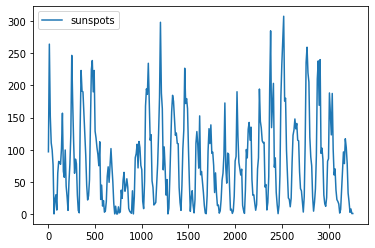

In [20]:
sns.lineplot(data=df[::10],);

We already are given the approximately, but this can be made more exact/verified by looking at the frequency distribution 
(the calculated [power spectral density](https://en.wikipedia.org/wiki/Spectral_density), known as a [periodogram](https://en.wikipedia.org/wiki/Periodogram))

Period at max in months: 130.6 months = 10.883333333333333 years.
Left, right: 136.04166666666666, 125.57692307692308 months.


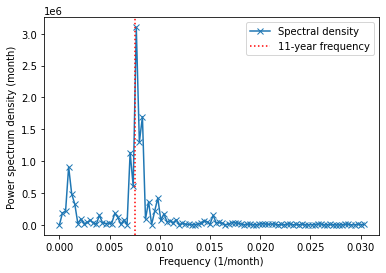

In [22]:
f, spec = periodogram(df.sunspots)

plt.plot(f[:100], spec[:100], 'x-', label='Spectral density')
plt.xlabel('Frequency (1/month)');
plt.ylabel("Power spectrum density (month)")

plt.axvline(x=1/(11*12), linestyle=':', color='red', label='11-year frequency')

plt.legend()
imax = np.argmax(spec)
left, center, right = 1/f[imax-1:imax+2] # years
print(f"Period at max in months: {center} months = {center/12} years.\nLeft, right: {left}, {right} months.")

However we see that there are also other relevatn frequencies in the spectrum, such as the peak at very low frequencies, corresponding to ~91 years.

When applying differencing methods for the modeling, a more direct metric for determining the seasonality (in integer units too) is to look at the autocorrelation function, i.e. the correlations of data separated by a certain lag. The autocorrelation and the spectral density are similar in that they both quantify correlations over time, but different (the relationship between them is given by the [Wiener-Khinchin theorem](https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem)).

2nd max autocorrelation value: [0.57929215 0.58087362 0.57577442]
Lag at 2nd max of autocorrelation: 128
Number of periods in dataset: 25.5078125


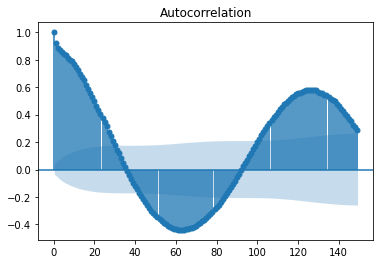

In [23]:
plot_acf(df.sunspots, lags=range(0,150));

acf_vals = acf(df.sunspots, nlags=150, fft=False)

# Find index of the second max
start = 60
period = np.argmax(acf_vals[start:]) + start
print("2nd max autocorrelation value:", acf_vals[period-1:period+2])
print("Lag at 2nd max of autocorrelation:", period)
print(f"Number of periods in dataset: {len(df)/period}")

# Baseline model: ARIMA

In [647]:
def predict_ARIMA(x, times, model, model_fit):
    "Make predictions for trained model using data x"
    if isinstance(model, ARIMA):
        tmp_model = ARIMA(x, order=model.order, trend=model.trend, seasonal_order=model.seasonal_order)
    else:
        tmp_model = SARIMAX(x, order=model.order, trend=model.trend, seasonal_order=model.seasonal_order)

    tmp_fit = tmp_model.smooth(model_fit.params)
    yhat = tmp_fit.predict(times[0], times[-1])
    return yhat

## Some preliminary tests
ARIMA(0,1,0) is a very simple model, just predicting the next month to be the same as the current month.

ARIMA model orders (0, 1, 0) (0, 0, 0, 128)
split: 2048, trend: None
{'mse': 692.6580197206245, 'mae': 18.875184880854558}


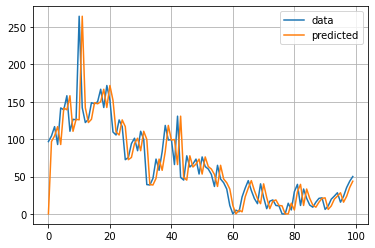

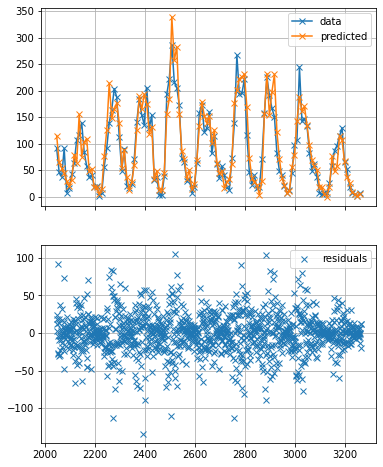

In [88]:
# Configuration
split = period*16
p, d, q = 0, 1, 0
P, D, Q, S = 0, 0, 0, period
seasonal_order = P, D, Q, S
order = (p, d, q)
trend = None if (d or D) else 'ct'
arima_config = dict(order=order, seasonal_order=seasonal_order, trend=trend)
print("ARIMA model orders", order, seasonal_order)    
print(f"split: {split}, trend: {trend}")

# Fit and predict
baseline = ARIMA(df.sunspots[:split], **arima_config)
baseline_fit = baseline.fit()
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), baseline, baseline_fit)

# plot
plt.grid()
plt.plot(df.sunspots[:100], label='data')
plt.plot(yhat[:100], label='predicted')
plt.legend()

fig, axes = plt.subplots(2,1, figsize=(6, 8), sharex=True)
ax = axes[0]
ax.grid()
ax.plot(df.sunspots[split::10], '-x', label='data')
ax.plot(yhat[split::10], '-x', label='predicted')
ax.legend()

ax = axes[1]
ax.grid()
res = yhat - df.sunspots
ax.plot(res[split:], 'x', label='residuals');
ax.legend()

# Print metrics
print(evaluate(df.sunspots[split:], yhat[split:]))

We see that already this model is doing pretty good in forecasting the next step. But there are still large residual values, seemingly periodically occurring. I try to see if adding seasonal differencing terms help, but it actually significantly decreases the performance of the model:

ARIMA model orders (0, 1, 0) (0, 1, 0, 128)
split: 2048, trend: None
{'mse': 1279.279745275281, 'mae': 25.886359901396993}


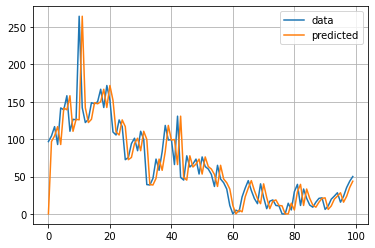

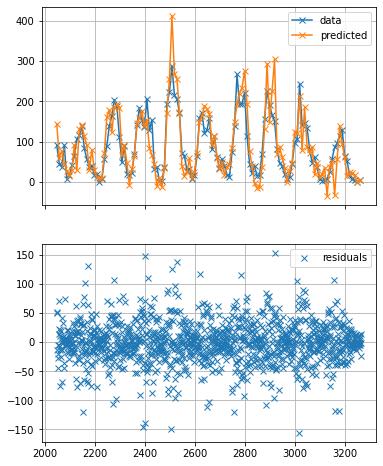

In [89]:
# Configuration
split = period*16
p, d, q = 0, 1, 0
P, D, Q, S = 0, 1, 0, period
seasonal_order = P, D, Q, S
order = (p, d, q)
trend = None if (d or D) else 'ct'
arima_config = dict(order=order, seasonal_order=seasonal_order, trend=trend)
print("ARIMA model orders", order, seasonal_order)    
print(f"split: {split}, trend: {trend}")

# Fit and predict
baseline = SARIMAX(df.sunspots[:split], **arima_config)
baseline_fit = baseline.fit()
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), baseline, baseline_fit)

# plot
plt.grid()
plt.plot(df.sunspots[:100], label='data')
plt.plot(yhat[:100], label='predicted')
plt.legend()

fig, axes = plt.subplots(2,1, figsize=(6, 8), sharex=True)
ax = axes[0]
ax.grid()
ax.plot(df.sunspots[split::10], '-x', label='data')
ax.plot(yhat[split::10], '-x', label='predicted')
ax.legend()

ax = axes[1]
ax.grid()
res = yhat - df.sunspots
ax.plot(res[split:], 'x', label='residuals');
ax.legend()

# Print metrics
print(evaluate(df.sunspots[split:], yhat[split:]))

As a last test I add an seasonal MA(1) term to see if that helps the seasonal ARIMA model compete with the naiva ARIMA(0,1,0) model:

ARIMA model orders (0, 1, 0) (0, 1, 1, 128)
split: 2048, trend: None
{'mse': 725.7241883005468, 'mae': 19.587603019185867}


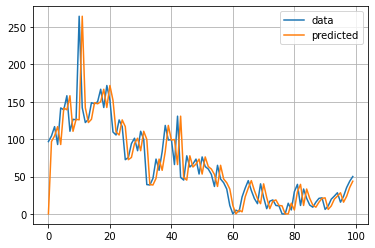

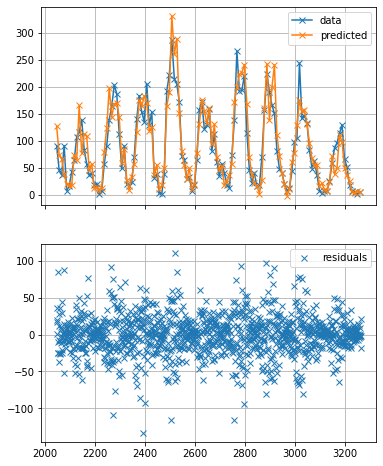

In [90]:
# Configuration
split = period*16
p, d, q = 0, 1, 0
P, D, Q, S = 0, 1, 1, period
seasonal_order = P, D, Q, S
order = (p, d, q)
trend = None if (d or D) else 'ct'
arima_config = dict(order=order, seasonal_order=seasonal_order, trend=trend)
print("ARIMA model orders", order, seasonal_order)    
print(f"split: {split}, trend: {trend}")

# Fit and predict
baseline = ARIMA(df.sunspots[:split], **arima_config)
baseline_fit = baseline.fit()
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), baseline, baseline_fit)

# plot
plt.grid()
plt.plot(df.sunspots[:100], label='data')
plt.plot(yhat[:100], label='predicted')
plt.legend()

fig, axes = plt.subplots(2,1, figsize=(6, 8), sharex=True)
ax = axes[0]
ax.grid()
ax.plot(df.sunspots[split::10], '-x', label='data')
ax.plot(yhat[split::10], '-x', label='predicted')
ax.legend()

ax = axes[1]
ax.grid()
res = yhat - df.sunspots
ax.plot(res[split:], 'x', label='residuals');
ax.legend()

# Print metrics
print(evaluate(df.sunspots[split:], yhat[split:]))

This did help decreasing both MSE and MAE, but still it performs significantly worse (MAE=19.6) than the simple ARIMA(0,1,0) model (MAE=18.9). It should be noted also that this took _much_ longer to fit and predict.

On the other hand one can note that the forecast done here was just one-step ahead. For multistep prediction, possible the seasonal model has advantages since it will have access to more data of the past. 

## Hyperparameter search

I want to perform a smallish hyperparmeter search for ARIAM to find a somewhat more competitive baseline.

Suprisingly (to me), as we saw above, adding seasonal components was not straightforward and required being bit restrictive. For instance, ARIMA$(0, 1, 0)(1, 1, 1)_{132}$ crashed the kernel. Potentially an implementation issue in the ARIMA function (using a lot of memory?) or in my implementation of the prediction). Other handpicked combinations deteriorated performance.
From what I understand, picking these parameter typically requires having some knowledge and experience; [Prof. Nau's](https://people.duke.edu/~rnau/seasarim.htm) lecture notes are a great resource for this. 

Here, I will skip seasonal orders becuase of the above reasons and perform a small search on non-seasonal orders only.

In [133]:
configs = itertools.product(*(range(7) for _ in range(3)), # p, d, q in (0, 1, 2, ...)
                            *(range(1) for _ in range(3)), # P, D, Q in (0)
                            (0,)) # seasonality in 0, 11 years (1 year = 12 months)

verbose = False
metrics = dict()

for i, c in enumerate(configs):
    if i % 10 == 0:
        print(i, end='\t')
    if i % 100  == 0:
        print()

    p, d, q, P, D, Q, S = c
    if S == 0 and max(P, D, Q) > 0:
        # Skip seasonal orders > 0 if S = 0 
        # (do only 0, 0, 0, 0)
        continue
    seasonal_order = P, D, Q, S
    order = (p, d, q)
    trend = None if (d or D) else 'ct'
    arima_config = dict(order=order, seasonal_order=seasonal_order, trend=trend)
    if verbose:
        print("ARIMA model orders", order, seasonal_order)    
        print(f"split: {split}, trend: {trend}")
    
    # Train on `split` number of samples
    model = ARIMA(df.sunspots[:split], **arima_config)
    try:
        fit = model.fit()
    except Exception as e:
        print ("Error in fit", e)
        continue

    # Validation MSE and MAE
    # Predict on all, evaluate on non-training data
    yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), model, fit)
    metrics[c] = evaluate(df.sunspots[split:], yhat[split:])
    
    if verbose:
        print(f"Metric: {metrics[c]}")
        print()

0	
10	20	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


30	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


40	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


50	60	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


70	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


80	90	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


100	


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


110	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

120	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

130	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error in fit LU decomposition error.


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


140	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


150	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

160	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

170	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

Error in fit LU decomposition error.
180	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

190	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


200	


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

210	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

220	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

230	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error in fit LU decomposition error.


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


240	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: No

250	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

260	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

270	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

280	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

Error in fit LU decomposition error.
290	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

300	


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

310	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

320	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

Error in fit LU decomposition error.


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


330	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum

340	

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [134]:
len(metrics)

338

In [355]:
def plot_pdq_distributions(metrics, name='mae', num_top=100):
    """Plot distributions of top configurations."""
    # Sort by the metrics
    mae = [(k, v[name]) for k, v in metrics.items()]
    mae.sort(key=lambda kv: kv[1])
    
    # Extract separate lists of the p, q, q hyperparameters
    configs, values = list(zip(*mae))
    ps, ds, qs, *_ = list(zip(*configs))

    fig, axes = plt.subplots(1,3, figsize=(3*4, 4))

    #for (i, x), name in zip(enumerate(top_pdq),'pdq'):
    plt.suptitle(f'Distribution of ARIMA (p,d,q) parameters for top {num_plot} configs')
    for params, name, i in zip([ps, ds, qs], 'pdq', range(3)):
        #print(len(params), name, i)
        sns.countplot(x=list(params)[:num_top], ax=axes[i], label=name, color='dodgerblue')
        axes[i].legend()

If we perform an analysis of the top 5% configurations, we see that $d=0$ sticks out as an important choice:

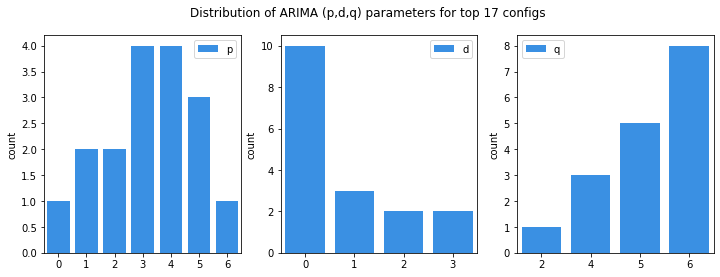

In [367]:
plot_pdq_distributions(metrics, num_top=len(metrics)//20 + 1)

Also, it looks like $p=3,4$ and $q=6$ (highest value) are good choices. Of course, one should keep in mind these kind of plots don't take into account any correlation between the different hyperparameters, just looks at the independently of on another. 

To get an idea of what how the actual performance values change with respect to the configurations, I plot the sorted MAE values:

In [368]:
def plot_metric_sorted(metrics, name='mae', num_plot=100):
    m = [(k, v[name]) for k, v in metrics.items()]
    m.sort(key=lambda kv: kv[1])
    configs, values= list(zip(*mae))

    fig, ax = plt.subplots(1)
    ax.plot(values[:num_plot], '-x', label=f'""{name} sorted by "{name}")')
    ax.legend()

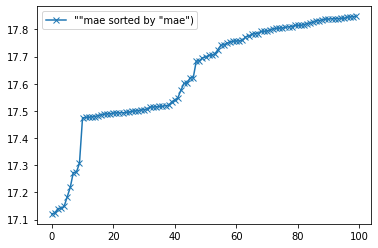

In [369]:
plot_metric_sorted(metrics)

It looks like there's a steep increase in MAE after the 10th best configuration, which is more like the  top 3%:

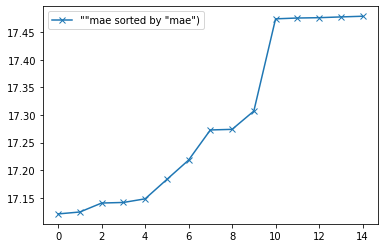

In [370]:
plot_metric_sorted(metrics, num_plot=15)

This means that the top 10 configurations form an elite "cluster" of a sort, which likely share some common features. Since there are quite few data points to deal with we can just look at them:

In [373]:
name='mae'
mae = [(k, v[name]) for k, v in metrics.items()]
mae.sort(key=lambda kv: kv[1])
for i, (k, v) in enumerate(mae[:15]):
    print(f"{i}: {k}, {v}")

0: (3, 0, 5, 0, 0, 0, 0), 17.120758657342208
1: (3, 0, 6, 0, 0, 0, 0), 17.1242484011605
2: (5, 0, 6, 0, 0, 0, 0), 17.14048447820643
3: (2, 0, 4, 0, 0, 0, 0), 17.14152782921944
4: (2, 0, 6, 0, 0, 0, 0), 17.148095960757352
5: (4, 0, 5, 0, 0, 0, 0), 17.183277039876305
6: (4, 0, 6, 0, 0, 0, 0), 17.218339505123183
7: (6, 0, 5, 0, 0, 0, 0), 17.272911960347162
8: (4, 0, 4, 0, 0, 0, 0), 17.274025588334126
9: (5, 0, 4, 0, 0, 0, 0), 17.307147965560976
10: (4, 3, 6, 0, 0, 0, 0), 17.47429699758533
11: (3, 1, 5, 0, 0, 0, 0), 17.47578570018287
12: (5, 1, 6, 0, 0, 0, 0), 17.476401634827837
13: (0, 2, 6, 0, 0, 0, 0), 17.477764135893025
14: (3, 3, 5, 0, 0, 0, 0), 17.47900422585776


It's clear that relatatively large $p$ and $q$ value together with $d=0$ works best. Although this is a small number of configurations, we can look at the counts of the $p$, $d$, $q$ parameters, as before but now only for the top 10 configurations. With larger nubmer of configurations scanned, this kind of analysis will make even more sense.

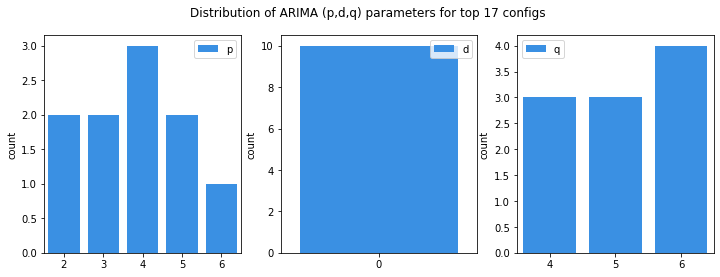

In [374]:
plot_pdq_distributions(metrics, num_top=10)

Based on this $2\leq p \leq5$, $d=0$ and $4\leq q\leq6$ are all good choices. Also, we see from this that there is not very much point in looking at larger $p$ and $q$ values for $d=0$.

## Result
In some cases, one might choose another configuration, for instance taking training time, model architecture or other metrics into account. 
In this case I just want a single configuration that works so I pick the best one,
$(p, d, q) = (3, 0, 5)$:

In [653]:
split = 16*period
order = (3, 0, 5)
trend = 'ct'

arima_config = dict(order=order, trend=trend)
print("ARIMA model orders", order)    
print(f"split: {split}, trend: {trend}")

# Train on `split` number of samples
model = ARIMA(df.sunspots[:split], **arima_config)
fit = model.fit()

# Validation MSE and MAE
# Predict on all, evaluate on non-training data
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), model, fit)

mae_base = evaluate(df.sunspots[split:], yhat[split:])['mae']
baseline_model = model
print(mae_base)

ARIMA model orders (3, 0, 5)
split: 2048, trend: ct


/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17.120758657342208


As a sidenote, I tried also using the SARIMAX implementation from Statsmodels, which gives somewhat different (worse) results:

In [656]:
# Train on `split` number of samples
model = SARIMAX(df.sunspots[:split], **arima_config)
fit = model.fit()

# Validation MSE and MAE
# Predict on all, evaluate on non-training data
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), model, fit)

print(evaluate(df.sunspots[split:], yhat[split:])['mae'])

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17.768469345479115


To get a second reference also tried using another train/validation split, with more data for training:

In [661]:
split = 24*period

# Train on `split` number of samples
model = ARIMA(df.sunspots[:split], **arima_config)
fit = model.fit()

# Validation MSE and MAE
# Predict on all, evaluate on non-training data
yhat = predict_ARIMA(df.sunspots, list(range(len(df.sunspots))), model, fit)

mae_base_2 = evaluate(df.sunspots[split:], yhat[split:])['mae']
print(mae_base_2)

/Users/elndvvc/.local/share/virtualenvs/timeseries-prediction-HP3a33iB/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10.851067691052291


# MLP model
Now I want to see how neural network models perform relative to my ARIMA baseline. I'll start with the simplest case, an MLP model.

In [33]:
# Based on: https://www.tensorflow.org/guide/data#time_series_windowing

def window_dataset(ds, window_size=5, shift=1, stride=1):
    """Return windowed dataset."""
    if not isinstance(ds, tf.data.Dataset) :
        ds = tf.data.Dataset.from_tensor_slices(ds)
    
    # Perform windowing. Result is nested, a dataset of "windows",
    # where each window is itself a dataset.
    windows = ds.window(window_size, shift=shift, stride=stride)

    # Transform window dataset into to batch datasets (with 1 sample)
    # and flatten results (concatenate batch datasets)
    def window_to_batch(window):
        # Make sure all windows are the same size by dropping remainder, if any.
        return window.batch(window_size, drop_remainder=True)

    windows = windows.flat_map(window_to_batch)

    return windows

In [9]:
def make_dataset(x, window_size=5, shuffle_buffer_size=None, batch_size=None):
    """Form input-to-output windows."""
    
    # Make windows of given size for predicting the value after the window (+1)
    # Elements: [x_i, ..., x_{i+w}]
    ds = window_dataset(x, window_size=window_size+1)

    # Map window of window_size-1 element (input) to last element (output)
    # Elements (tuple): ([x_i, ..., x_{i+w-1}], x_{i+w})
    #return ds.map(lambda z: z[-1])
    ds = ds.map(lambda z: (z[:-1], z[-1:]))
    
    # Shuffle and batch
    if shuffle_buffer_size:
        ds = ds.shuffle(shuffle_buffer_size)
    if batch_size:
        # Allow the last batch to be smaller
        ds = ds.batch(batch_size, drop_remainder=False)
    
    return ds

In [10]:
def mlp_model(input_shape, output_shape, num_nodes=10, activation='relu'):
    model = tf.keras.Sequential()
    
    #  Allow more general input shape
    model.add(tf.keras.layers.Flatten(input_shape=input_shape))
    
    # Add layers with given number of nodes.
    # Nodes can be iterable or integer (single layer)
    if isinstance(num_nodes, int):
        num_nodes = [num_nodes]
    for num in num_nodes:
        model.add(tf.keras.layers.Dense(num, activation=activation))

    # Output layer (allow for more general output shape)
    num_out = 1
    for num in output_shape:
        if num:
            num_out *= num
    model.add(tf.keras.layers.Dense(num_out))
    model.add(tf.keras.layers.Reshape(output_shape))

    return model

In [41]:
def input_output_shapes(dataset):
    """Extract input and output shapes of a Tensorflow dataset."""
    return tuple((tuple((dim for dim in spec.shape if dim)) for spec in dataset.element_spec))

In [246]:
# Training and model config 

# for the dataset
shuffle_buffer_size = len(df)
batch_size = 32
split = period*16
window_size = 5

# for the model
num_nodes = [10, 10]
activation='relu'

# For `model.fit`
optimizer_cls = tf.keras.optimizers.Adam
optimizer_config = dict(lr=1e-8, beta_1=0.9)
metrics = ['mae', 'mse']c
loss = tf.keras.losses.MeanSquaredError()
epochs = 100
callbacks = []

In [247]:
# Set numpy and tensorflow seeds and reset Tensorflow global state
# (https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session)
seed = 37
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
np.random.seed(seed)

In [248]:
ds_train = make_dataset(df.sunspots[:split], window_size=window_size, shuffle_buffer_size=shuffle_buffer_size, batch_size=batch_size)
model = mlp_model(*input_output_shapes(ds), num_nodes=num_nodes, activation=activation)
model.summary()
model.compile(loss=loss, optimizer=optimizer_cls(**optimizer_config), metrics=metrics)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
reshape (Reshape)            (None, 1)                 0         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


## Dynamical learning rate tuning
The learning rate is known to be important so I'll tune that first by compiling the model to use a Tensorflow callback.

In [249]:
def learning_rate_at_epoch(epoch):
    return 1e-8 * 10**(epoch/20)

In [253]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(learning_rate_at_epoch)
callbacks = [lr_schedule]
optimizer = optimizer_cls(lr=learning_rate_at_epoch(0), beta_1=0.9)

model.compile(optimizer=optimizer, loss=loss)

In [254]:
history = model.fit(ds_train, epochs=200, callbacks=callbacks, verbose=0)

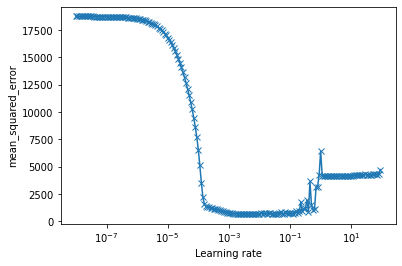

In [255]:
plt.semilogx(history.history['lr'], history.history['loss'], 'x-');
plt.xlabel('Learning rate')
plt.ylabel(f'{loss.name}');

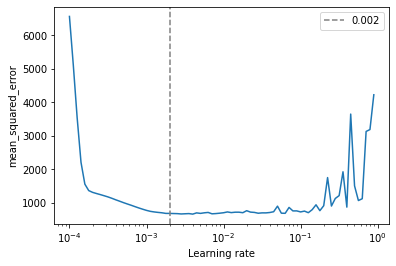

In [257]:
s = slice(80,-40)
plt.semilogx(history.history['lr'][s], history.history['loss'][s])
plt.xlabel('Learning rate')
plt.ylabel(f'{loss.name}')
lr_min = 2e-3
plt.axvline(lr_min, linestyle='--', color='grey', label=str(lr_min))
plt.legend();

Somewhere between $10^{-3}$ and $10^{-2}$ seems to be a good value. So I'll pick $2\cdot10^{-3}$.

In [259]:
optimizer_config['lr'] = 2e-3

## Training

In [752]:
def plot_metric(metric, start=None, end=None, skip=None, xlabel='epochs', ylabel='mae', linestyle='-', marker='x'):
    s = slice(start, end, skip)
    plt.plot(metric[s], linestyle=linestyle, marker=marker)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [277]:
# Set numpy and tensorflow seeds and reset Tensorflow global state
# (https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session)
seed = 37
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
np.random.seed(seed)

ds_train = make_dataset(df.sunspots[:split], window_size=window_size, shuffle_buffer_size=shuffle_buffer_size, batch_size=batch_size)
model = mlp_model(*input_output_shapes(ds_train), num_nodes=num_nodes, activation=activation)
model.compile(loss=loss, optimizer=optimizer_cls(**optimizer_config), metrics=metrics)

In [278]:
history = model.fit(ds_train, epochs=100, callbacks=[], verbose=0)

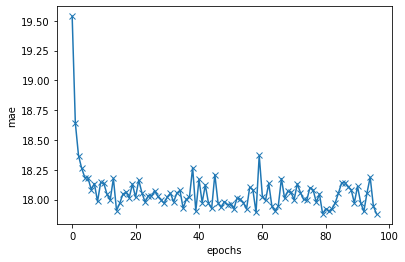

In [377]:
plot_metric(history.history['mae'], start=3)

## Predict/evaluate

In [527]:
def predict(y, model, in_sample=True):
    """Return predictions for y.
    
    This implementation will not do out-of-sample forecast (the next unseen time).
    """
    # Dataset for evaluating, windowed input for prediction
    window_size = model.input_shape[-1]
    ds_valid = make_dataset(y, window_size=window_size, batch_size=32)
    ds_x = ds_valid.map(lambda x, y: x)
    
    # Predictions, padded with zeroes 
    yhat = np.zeros(y.shape)
    yhat[window_size:] = model.predict(ds_x).ravel()
    
    end = None if in_sample else -1
    
    if isinstance(y, pd.Series):
        # Return same type as given
        yhat = pd.Series(yhat).reindex_like(df.sunspots)
        
    return yhat[:end]

In [528]:
yhat = predict(df.sunspots, model)

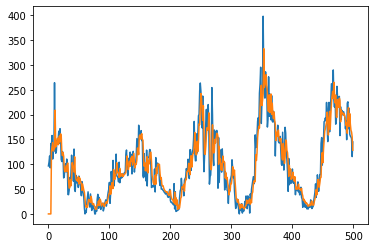

In [529]:
s = slice(0, 500)
plt.plot(df.sunspots[s] ,'-')
plt.plot(yhat[s], '-')

In [538]:
s = slice(split, None)
mae = evaluate(yhat[s], df.sunspots[s])['mae']
print(f"MAE = {mae} (baseline = {mae_base})")

MAE = 17.873312581045862 (baseline = 17.120758657342208)


## Manual tuning

This model is still not improving on the baseline. To improve on this using the same basic architecture, I'll try tuning/exploring:

- the window size
- number of epochs
- loss function
- number of nodes
- batch size
- data scaling
- activation function

In [710]:
def evaluate_parameter(y, window_size=5, split=2048, batch_size=32,
                       activation='relu', loss='mse', 
                       num_nodes=(10, 10), epochs=100):
    # Set numpy and tensorflow seeds and reset Tensorflow global state
    # (https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session)
    seed = 37
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)

    ds_train = make_dataset(y[:split], window_size=window_size, shuffle_buffer_size=shuffle_buffer_size, batch_size=batch_size)
    model = mlp_model(*input_output_shapes(ds_train), num_nodes=num_nodes, activation=activation)
    model.compile(loss=loss, optimizer=optimizer_cls(**optimizer_config), metrics=metrics)

    history = model.fit(ds_train, epochs=epochs, callbacks=[], verbose=0)

    yhat = predict(y, model)
    s = slice(split, None)
    mae = evaluate(yhat[s], y[s])['mae']

    return mae, model, history

### Window size
The window size is likely to matter a lot since it defines how much memory back in time the model has access to when making tuning the predictions.

In [665]:
windows = [10*(i+1) for i in range(10)]
for window_size in windows:
    print(f"Training model using window_size={window_size}")
    mae, model = evaluate_parameter(df.sunspots, window_size=window_size)
    print(f"MAE = {mae} (baseline = {mae_base})")
print('-'*80)

Training model using window_size=10
MAE = 18.56919377647469 (baseline = 17.120758657342208)
Training model using window_size=20
MAE = 17.905529089216923 (baseline = 17.120758657342208)
Training model using window_size=30
MAE = 17.30075868304479 (baseline = 17.120758657342208)
Training model using window_size=40
MAE = 17.388312569630372 (baseline = 17.120758657342208)
Training model using window_size=50
MAE = 17.794673993035033 (baseline = 17.120758657342208)
Training model using window_size=60
MAE = 17.733677769569265 (baseline = 17.120758657342208)
Training model using window_size=70
MAE = 17.96732913628894 (baseline = 17.120758657342208)
Training model using window_size=80
MAE = 17.825149435515076 (baseline = 17.120758657342208)
Training model using window_size=90
MAE = 18.241425276155244 (baseline = 17.120758657342208)
Training model using window_size=100
MAE = 17.905906601586885 (baseline = 17.120758657342208)
------------------------------------------------------------------------

Based on this a window size of 30 is an improvement, but still the model is worse than the baseline. Perhaps which model is better is also the amount of data used. To try that hypothesis I compare to the second baseline value, where I had a more "aggressive" split of 94% of the data going to training.

In [678]:
split1 = 16*period
split2 = 24*period
print(split1/num_times, split2/num_times)

0.6272588055130168 0.9408882082695252


In [666]:
mae, model = evaluate_parameter(df.sunspots, window_size=30, split=split2)
print(f"MAE = {mae} (baseline = {mae_base_2})")

MAE = 10.791286143861287 (baseline = 10.851067691052291)


Now the MLP model _slightly_ outperforms the ARIMA model. If we make the window size larger we see the MLP advantage grows:

In [667]:
mae, model = evaluate_parameter(df.sunspots, window_size=60, split=split2)
print(f"MAE = {mae} (baseline = {mae_base_2})")

MAE = 10.33119246947333 (baseline = 10.851067691052291)


This makes sens as more data for training enables larger window sizes.

It should be noted that this is not entirely fair, as I didn't tune the ARIMA orders for this split of data so I'll stick to the original split (63% training data) here.

In [687]:
window_size=30

### Number of epochs
Increasing the number of epochs however I see that the MAE is actually getting worse:

In [755]:
mae, model, history = evaluate_parameter(
    df.sunspots,
    window_size=30,
    epochs=500
)
print(f"MAE = {mae} (baseline = {mae_base})")

MAE = 18.77642349575814 (baseline = 17.120758657342208)


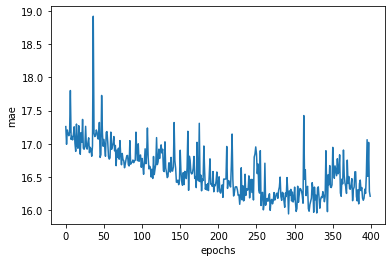

In [756]:
plot_metric(history.history['mae'][100:], marker='')

Perhaps increasing changing the loss function helps?

### Loss function
I try using the Huber loss which is a more robust metric than MSE.

In [757]:
mae, model, history = evaluate_parameter(
    df.sunspots,
    loss='huber',
    window_size=30,
    epochs=500
)
print(f"MAE = {mae} (baseline = {mae_base})")

MAE = 17.926820532915137 (baseline = 17.120758657342208)


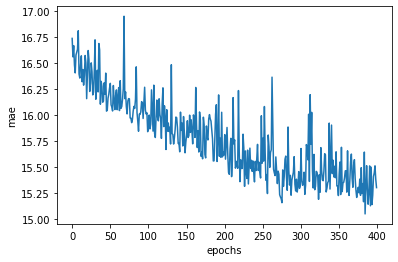

In [758]:
plot_metric(history.history['mae'][100:], marker='')

This does seem to improve the training, although it could be just by chance. In any case it doesn't seem to hurt, so I'll use it.

In [759]:
loss='huber'

### Batch size
The batch size should also be important for convergence. I'll try using a larger batch size than 32.

MAE = 17.655061184914267 (baseline = 17.120758657342208)


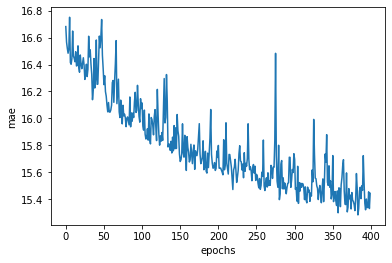

In [777]:
mae, model, history = evaluate_parameter(
    df.sunspots,
    batch_size=128,
    loss='huber',
    window_size=30,
    epochs=500
)
print(f"MAE = {mae} (baseline = {mae_base})")

plot_metric(history.history['mae'][100:], marker='')

This seems to offer some imrovement, the training curve looks sightly less noisy and the validation error is lower.

### Standardization scaling 
So far, I haven't used any scaling of the observations, which is generally common procedure. I check if this helps.

In [813]:
mu, sigma = np.mean(df.sunspots), np.std(df.sunspots)
print(mu, sigma)
y_normalized = (df.sunspots - mu)/sigma
print(np.mean(y_normalized), np.std(y_normalized))

81.77877488514548 67.87887920173986
1.4145567480675807e-17 1.0


MAE = 0.28829399365662917 (baseline = 17.120758657342208)


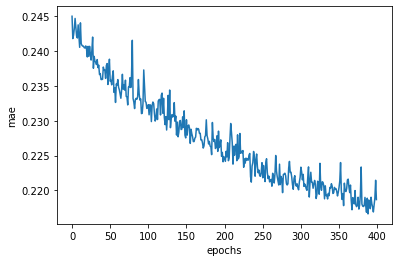

In [785]:
mae, model, history = evaluate_parameter(
    y_normalized,
    batch_size=128,
    loss='huber',
    window_size=30,
    epochs=500
)
print(f"MAE = {mae} (baseline = {mae_base})")

plot_metric(history.history['mae'][100:], marker='')

Of course, to really evaluate this I need to scale back.

In [809]:
yhat_normalized = predict(y_normalized, model)
yhat = yhat_normalized*sigma + mu
s = slice(split, None)
mae = evaluate(yhat[s], df.sunspots[s])['mae']
print(mae)

19.56907317000549


Somewhat surprisingly, this didn't help straight off the bat. 

### Min-max scaling

In [817]:
ymin, ymax = min(df.sunspots),max(df.sunspots)
mu, sigma = ymin, (ymax - ymin)
print(mu, sigma)
y_normalized = (df.sunspots - mu)/sigma
print(np.mean(y_normalized), np.std(y_normalized))

0.0 398.2
0.20537110719524232 0.17046428729718702


MAE = 0.045131844135786095 (baseline = 17.120758657342208)


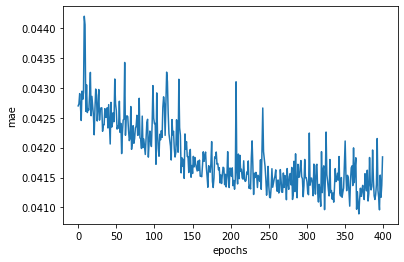

In [818]:
mae, model, history = evaluate_parameter(
    y_normalized,
    batch_size=128,
    loss='huber',
    window_size=30,
    epochs=500
)
print(f"MAE = {mae} (baseline = {mae_base})")

plot_metric(history.history['mae'][100:], marker='')

In [819]:
yhat_normalized = predict(y_normalized, model)
yhat = yhat_normalized*sigma + mu
s = slice(split, None)
mae = evaluate(yhat[s], df.sunspots[s])['mae']
print(mae)

17.971500334870026


This helped more than normalizing using standard deviation and mean, but still seems to not be a deal-breaker so I'll skip it for now for simplicity.

### Number of nodes
It also makes some intuitive sense that the first layer of nodes should scale with the size of the input space. The width of a neural network generally increases with the "complexity" or dimensionality of the input. This indeed yields a small improvement:

MAE = 19.08552357114135 (baseline = 17.120758657342208)


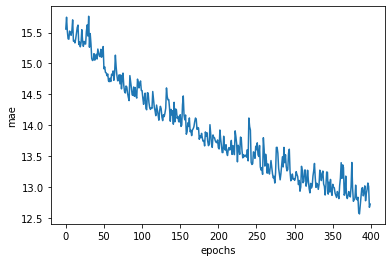

In [824]:
mae, model, history = evaluate_parameter(
    df.sunspots,
    num_nodes=(30, 10),
    batch_size=128,
    loss='huber',
    window_size=30,
    epochs=500
)
print(f"MAE = {mae} (baseline = {mae_base})")

plot_metric(history.history['mae'][100:], marker='')

This does not give a lower validation error, but interestingly it does give significantly lower training errors (previously MAE=15 after 500 epochs). This shows a tendency of overfitting, which makes sense since the larger number of nodes made the model more complex.  If there were more training data (or using a different split), this may given an advantage.

In [704]:
num_nodes=(30, 10)

### Activation function

MAE = 39.217215498843544 (baseline = 17.120758657342208)


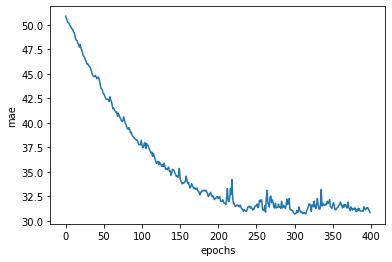

In [827]:
mae, model, history = evaluate_parameter(
    df.sunspots,
    activation='tanh',
    num_nodes=(10, 10),
    batch_size=128,
    loss='huber',
    window_size=30,
    epochs=500
)
print(f"MAE = {mae} (baseline = {mae_base})")

plot_metric(history.history['mae'][100:], marker='')

I'm not sure why $\tanh$ performs so badly, but I will just stick to ReLU without investigating this further.

MAE = 17.32517459739058 (baseline = 17.120758657342208)


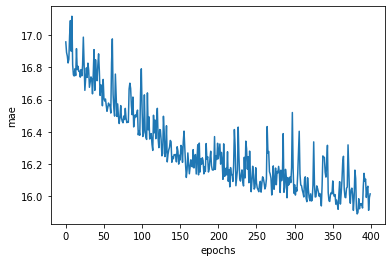

In [834]:
mae, model, history = evaluate_parameter(
    df.sunspots,
    activation='elu',
    num_nodes=(10, 10),
    batch_size=128,
    loss='huber',
    window_size=30,
    epochs=500
)
print(f"MAE = {mae} (baseline = {mae_base})")

plot_metric(history.history['mae'][100:], marker='')

The `elu` activation gives the lowest validation error, so I'll use this.

In [835]:
activation='elu'

### Regularization
Based on the above manual tuning, it seems like there is a tendency of overfitting. The dataset is not very large after all. For that I'll add some regularization strategies, see e.g [Tensorflow's tutorial on these](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

In [838]:
def evaluate_parameter(y, window_size=5, split=2048, batch_size=32,
                       activation='relu', loss='mse', 
                       num_nodes=(10, 10), epochs=100,
                       dropout=None
                      ):
    # Set numpy and tensorflow seeds and reset Tensorflow global state
    # (https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session)
    seed = 37
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)

    ds_train = make_dataset(y[:split], window_size=window_size, shuffle_buffer_size=shuffle_buffer_size, batch_size=batch_size)
    model = mlp_model(*input_output_shapes(ds_train), num_nodes=num_nodes, activation=activation, dropout=dropout)
    model.compile(loss=loss, optimizer=optimizer_cls(**optimizer_config), metrics=metrics)

    history = model.fit(ds_train, epochs=epochs, callbacks=[], verbose=0)

    yhat = predict(y, model)
    s = slice(split, None)
    mae = evaluate(yhat[s], y[s])['mae']

    return mae, model, history

In [841]:
def mlp_model(input_shape, output_shape, num_nodes=10, activation='relu',
              dropout=None, l2_regularization=None):
    model = tf.keras.Sequential()
    
    #  Allow more general input shape
    model.add(tf.keras.layers.Flatten(input_shape=input_shape))
    
    # Add layers with given number of nodes.
    # Nodes can be iterable or integer (single layer)
    if isinstance(num_nodes, int):
        num_nodes = [num_nodes]
    for num in num_nodes:
        model.add(tf.keras.layers.Dense(num, activation=activation))
        if dropout:
            model.add(tf.keras.layers.Dropout(dropout))

    # Output layer (allow for more general output shape)
    num_out = 1
    for num in output_shape:
        if num:
            num_out *= num
    model.add(tf.keras.layers.Dense(num_out))
    model.add(tf.keras.layers.Reshape(output_shape))

    return model

In [861]:
mae, model, history = evaluate_parameter(
    df.sunspots,
    dropout=0.1,
    activation='elu',
    num_nodes=(10, 10),
    batch_size=128,
    loss='mse',
    window_size=30,
    epochs=500,
)
print(f"MAE = {mae} (baseline = {mae_base})")

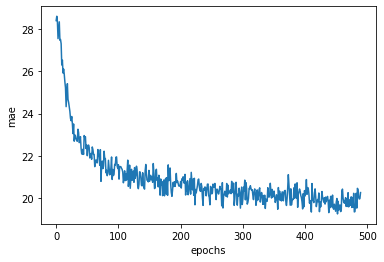

In [864]:
plot_metric(history.history['mae'][10:], marker='')

In [865]:
mae, model, history = evaluate_parameter(
    df.sunspots,
    activation='elu',
    num_nodes=(5, 5),
    batch_size=128,
    loss='mse',
    window_size=30,
    epochs=500,
)
print(f"MAE = {mae} (baseline = {mae_base})")

MAE = 17.715949018401204 (baseline = 17.120758657342208)


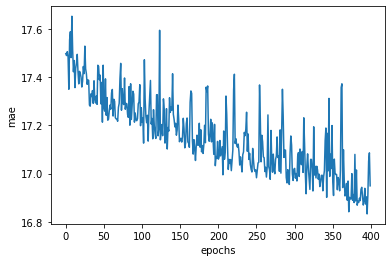

In [867]:
plot_metric(history.history['mae'][100:], marker='')

# LSTM

# Convolutional layers

# RNN